In [1]:
!nvidia-smi

Mon Jul 22 00:44:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:06.0 Off |                    0 |
| N/A   32C    P8              10W /  70W |      2MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


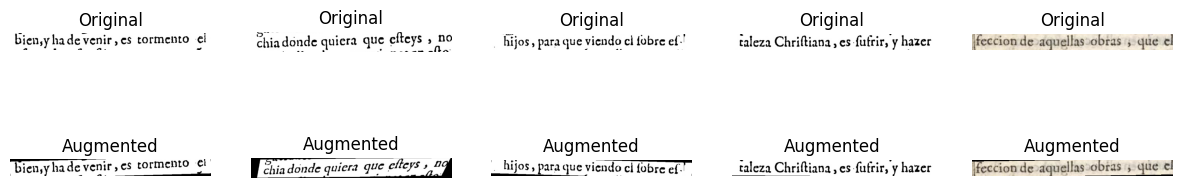

In [3]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, TrainingArguments, Trainer
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import Levenshtein as lev
from datasets import load_metric
from transformers import get_linear_schedule_with_warmup, AdamW
import wandb
from torch.optim import AdamW
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, EarlyStoppingCallback, TrOCRProcessor, VisionEncoderDecoderModel
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import random
# Login to wandb
wandb.login(key="Your-wandb-key")

# Initialize wandb project
wandb.init(project="trocr-ocr-finetuning")

# Define the data augmentation pipeline for OCR
data_transforms_train = transforms.Compose([
    transforms.RandomRotation(degrees=3),  # Increase rotation to 40 degrees
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5)  # Random perspective transformation
])

data_transforms_val = transforms.Compose([])

class SpanishDocumentsDataset(Dataset):
    def __init__(self, image_dir, text_dir, processor, transform=None):
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.processor = processor
        self.transform = transform
        self.filenames = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        image_file = self.filenames[idx]
        text_file = image_file.replace('.jpg', '.txt')
        
        image_path = os.path.join(self.image_dir, image_file)
        text_path = os.path.join(self.text_dir, text_file)
        
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            augmented_image = self.transform(image)
            # print(f"Applied Transformations to Image {idx}")  # Debug statement
        else:
            augmented_image = image
        
        pixel_values = self.processor.feature_extractor(images=augmented_image, return_tensors="pt").pixel_values.squeeze()

        with open(text_path, 'r', encoding='utf-8') as file:
            text = file.read().strip()
        labels = self.processor.tokenizer(text, return_tensors="pt").input_ids.squeeze()
        
        labels[labels == self.processor.tokenizer.pad_token_id] = -100
        
        return {"pixel_values": pixel_values, "labels": labels, "original_image": image, "augmented_image": augmented_image}

image_dir = '../../data/train/All_line_segments'
text_dir = '../../data/train/All_line_texts'

def collate_fn(batch):
    pixel_values = [item['pixel_values'] for item in batch]
    labels = [item['labels'] for item in batch]
    
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)
    pixel_values = torch.stack(pixel_values)
    
    return {"pixel_values": pixel_values, "labels": labels}

# Initialize processor and model with correct configurations
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-printed")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-printed")

# Set dropout probabilities
# model.config.encoder.hidden_dropout_prob = 0.1
# model.config.decoder.dropout = 0.1

# Model configuration
model.config.decoder_start_token_id = processor.tokenizer.bos_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.eos_token_id = processor.tokenizer.eos_token_id
model.config.ignore_pad_token_for_loss = True  # Ensure pad tokens are ignored during loss calculation
model.config.vocab_size = model.config.decoder.vocab_size
# Set beam search parameters
# model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 5

dataset_train = SpanishDocumentsDataset(image_dir, text_dir, processor=processor, transform=data_transforms_train)
dataset_val = SpanishDocumentsDataset(image_dir, text_dir, processor=processor, transform=data_transforms_val)

dataset_size = len(dataset_train)
eval_size = int(dataset_size * 0.1)
train_size = dataset_size - eval_size

train_dataset, eval_dataset = random_split(dataset_train, [train_size, eval_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
eval_loader = DataLoader(eval_dataset, batch_size=8, collate_fn=collate_fn)

# Function to visualize original and augmented samples
def visualize_random_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        sample_idx = random.randint(0, len(dataset) - 1)
        sample = dataset[sample_idx]
        original_image = sample['original_image']
        augmented_image = sample['augmented_image']
        
        # Show original image
        axes[0, i].imshow(original_image)
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        
        # Show augmented image
        axes[1, i].imshow(augmented_image)
        axes[1, i].set_title("Augmented")
        axes[1, i].axis('off')
    
    plt.show()

# Visualize random samples from the training dataset
visualize_random_samples(train_dataset)


In [4]:
# # To see how the data is loaded, let's fetch a batch from the DataLoader
print(len(train_loader))
for batch in train_loader:
    print(batch['pixel_values'].shape, batch['labels'].shape)
    break  # Just show the first batch for demonstration

225
torch.Size([8, 3, 384, 384]) torch.Size([8, 15])


In [5]:
from transformers import get_cosine_schedule_with_warmup
# Define the CustomLoss class
class CustomLoss(nn.Module):
    def __init__(self, beta=1.0):
        super(CustomLoss, self).__init__()
        self.beta = beta

    def forward(self, logits, labels, similarities, seq_len):
        # Flatten logits and labels for easy indexing
        batch_size, _, vocab_size = logits.shape
        logits = logits.view(-1, vocab_size)
        labels = labels.view(-1)

        # Compute the log-probabilities
        log_probs = F.log_softmax(logits, dim=-1)

        # Gather the log-probability of the correct class
        correct_class_logit = log_probs[range(logits.size(0)), labels]

        # Create a mask to filter out padding tokens
        pad_mask = labels != -100

        # Filter valid logits and labels
        valid_logits = logits[pad_mask]
        valid_labels = labels[pad_mask]
        correct_class_logit = correct_class_logit[pad_mask]

        # Compute the highest incorrect class logit
        mask = torch.zeros_like(valid_logits).scatter_(1, valid_labels.unsqueeze(1), float('-inf'))
        highest_incorrect_class_logit = torch.max(valid_logits + mask, dim=1)[0]

        # Move similarities to the same device as logits
        device = logits.device
        similarities = similarities.to(device)

        # Reshape similarities to match the valid labels/logits shape
        valid_similarities = similarities.view(batch_size * seq_len, 2)[pad_mask]

        # Ensure valid_similarities has the correct shape
        valid_similarities = valid_similarities.view(-1, 2)

        # Compute margin loss
        margin_loss = torch.clamp(
            self.beta * (valid_similarities[:, 0] - valid_similarities[:, 1]) - correct_class_logit + highest_incorrect_class_logit + 1,
            min=0
        ).mean()

        return margin_loss

# Initialize the loss function
loss_fn = CustomLoss()

# Load the CER metric
cer_metric = load_metric("cer", trust_remote_code=True)

# Define the compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred.predictions, eval_pred.label_ids
    
    # Handle cases where logits might be a tuple
    if isinstance(logits, tuple):
        logits = logits[0]

    predictions = logits.argmax(-1)

    decoded_preds = processor.batch_decode(predictions, skip_special_tokens=True)
    
    # Decode the labels
    labels = [[label for label in sequence if label != -100] for sequence in labels]
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    
    cer = cer_metric.compute(predictions=decoded_preds, references=decoded_labels)
    
    return {"cer": cer}

# Define the output directory
model_dir = "../../models/trocr_finetuned_printed_calibrated"
os.makedirs(model_dir, exist_ok=True)

# Define the training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir=model_dir,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    fp16=False,
    gradient_accumulation_steps=1,
    max_grad_norm=1.0,
    num_train_epochs=30,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=200,
    save_steps=100000,
    warmup_steps=500,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to="wandb",
)

# Calculate total training steps
total_train_steps = (len(train_loader) * training_args.num_train_epochs)

# Define the optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-6)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=total_train_steps)
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=500,
    num_training_steps=total_train_steps
)


# Create the EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.0)

# Define the CustomTrainer class
class CustomTrainer(Seq2SeqTrainer):
    def __init__(self, model, args, data_collator, train_dataset, eval_dataset, tokenizer, compute_metrics, optimizers):
        super().__init__(model, args, data_collator=data_collator, train_dataset=train_dataset, eval_dataset=eval_dataset, tokenizer=tokenizer, optimizers=optimizers)
        self.loss_fn = CustomLoss()
        self.compute_metrics = compute_metrics  # Set compute_metrics as an attribute

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs, labels=labels)
        logits = outputs.logits
        
        ce_loss = outputs.loss
        
        # Pass batch_size and seq_len to compute_similarities
        batch_size = labels.shape[0]
        seq_len = logits.shape[1]
        similarities = self.compute_similarities(logits, labels, batch_size, seq_len)
        
        margin_loss = self.loss_fn(logits, labels, similarities, seq_len)
        
        total_loss = margin_loss # + ce_loss
        
        return (total_loss, outputs) if return_outputs else total_loss

    # def compute_similarities(self, logits, labels, batch_size, seq_len):
    #     decoded_preds = logits.argmax(-1)
    #     decoded_labels = labels.clone()
        
    #     # Access the vocabulary size from the model configuration
    #     vocab_size = self.model.config.vocab_size
        
    #     # Ensure the token IDs are within the valid range
    #     decoded_preds = torch.clamp(decoded_preds, min=0, max=vocab_size - 1)
    #     decoded_labels = torch.clamp(decoded_labels, min=0, max=vocab_size - 1)
        
    #     decoded_preds = decoded_preds.cpu().tolist()
    #     decoded_labels = decoded_labels.cpu().tolist()
        
    #     # Decode all predictions and labels at once
    #     try:
    #         decoded_preds_str = self.tokenizer.batch_decode(decoded_preds, skip_special_tokens=True)
    #         decoded_labels_str = self.tokenizer.batch_decode(decoded_labels, skip_special_tokens=True)
    #     except Exception as e:
    #         # print(f"Error in batch decoding: {e}")
    #         raise e
        
    #     # Ensure proper reshaping of decoded strings
    #     decoded_preds_str = [decoded_preds_str[i:i + seq_len] for i in range(0, len(decoded_preds_str), seq_len)]
    #     decoded_labels_str = [decoded_labels_str[i:i + seq_len] for i in range(0, len(decoded_labels_str), seq_len)]
        
    #     # Debugging: Print sequences before decoding
    #     # print(f"Decoded Predictions (token IDs): {decoded_preds}")
    #     # print(f"Decoded Labels (token IDs): {decoded_labels}")
        
    #     # Debugging: Print sequences after decoding
    #     # print(f"Decoded Predictions (strings): {decoded_preds_str}")
    #     # print(f"Decoded Labels (strings): {decoded_labels_str}")
        
    #     similarities = []
    #     for batch_idx in range(batch_size):
    #         for seq_idx in range(seq_len):
    #             try:
    #                 pred_str = decoded_preds_str[batch_idx][seq_idx]
    #                 label_str = decoded_labels_str[batch_idx][seq_idx]
                    
    #                 # Check for empty strings
    #                 if not pred_str.strip() or not label_str.strip():
    #                     raise ValueError("One or more references are empty strings")
                    
    #                 cer = cer_metric.compute(predictions=[pred_str], references=[label_str])
    #                 similarities.append([1 - cer, cer])
    #             except Exception as e:
    #                 # print(f"Error decoding sequences at batch {batch_idx}, seq {seq_idx}: {e}")
    #                 similarities.append([0, 1])  # Default similarity in case of error
        
    #     # Debugging statements
    #     # print(f"Batch size: {batch_size}")
    #     # print(f"Sequence length: {seq_len}")
    #     # print(f"Number of similarities: {len(similarities)}")
    #     # if len(similarities) > 0:
    #     #     print(f"Shape of one similarity element: {torch.tensor(similarities[0]).shape}")
        
    #     # Ensure the total size matches batch_size * seq_len * 2
    #     total_elements = batch_size * seq_len * 2
    #     actual_elements = len(similarities) * 2
        
    #     # print(f"Total elements expected: {total_elements}")
    #     # print(f"Actual elements: {actual_elements}")
        
    #     if total_elements != actual_elements:
    #         raise ValueError(f"Mismatch in the number of elements. Expected {total_elements}, but got {actual_elements}.")
        
    #     # Return a tensor of shape (batch_size, seq_len, 2)
    #     similarities_tensor = torch.tensor(similarities).view(batch_size, seq_len, 2)
    #     # print(f"Similarities tensor shape: {similarities_tensor.shape}")
    #     return similarities_tensor


    def compute_similarities(self, logits, labels, batch_size, seq_len):
        decoded_preds = logits.argmax(-1)
        decoded_labels = labels.clone()
        
        # Access the vocabulary size from the model configuration
        vocab_size = self.model.config.vocab_size
        
        # Ensure the token IDs are within the valid range
        decoded_preds = torch.clamp(decoded_preds, min=0, max=vocab_size - 1)
        decoded_labels = torch.clamp(decoded_labels, min=0, max=vocab_size - 1)
        
        # Convert to lists for batch decoding
        decoded_preds = decoded_preds.cpu().tolist()
        decoded_labels = decoded_labels.cpu().tolist()
        
        # Decode all predictions and labels at once
        try:
            decoded_preds_str = self.tokenizer.batch_decode(decoded_preds, skip_special_tokens=True)
            decoded_labels_str = self.tokenizer.batch_decode(decoded_labels, skip_special_tokens=True)
        except Exception as e:
            # print(f"Error in batch decoding: {e}")
            raise e
        
        # Ensure proper reshaping of decoded strings
        try:
            decoded_preds_str = [decoded_preds_str[i:i + seq_len] for i in range(0, len(decoded_preds_str), seq_len)]
            decoded_labels_str = [decoded_labels_str[i:i + seq_len] for i in range(0, len(decoded_labels_str), seq_len)]
        except Exception as e:
            # print(f"Error reshaping decoded strings: {e}")
            raise e
        
        # Debugging: Print sequences before decoding
        # print(f"Decoded Predictions (token IDs): {decoded_preds}")
        # print(f"Decoded Labels (token IDs): {decoded_labels}")
        
        # Debugging: Print sequences after decoding
        # print(f"Decoded Predictions (strings): {decoded_preds_str}")
        # print(f"Decoded Labels (strings): {decoded_labels_str}")
        
        # Check lengths
        # if len(decoded_preds_str) != batch_size or any(len(pred) != seq_len for pred in decoded_preds_str):
        #     print(f"Mismatch in length of decoded_preds_str: {len(decoded_preds_str)}")
        # if len(decoded_labels_str) != batch_size or any(len(label) != seq_len for label in decoded_labels_str):
        #     print(f"Mismatch in length of decoded_labels_str: {len(decoded_labels_str)}")
        
        similarities = []
        for batch_idx in range(batch_size):
            for seq_idx in range(seq_len):
                try:
                    pred_str = decoded_preds_str[batch_idx][seq_idx]
                    label_str = decoded_labels_str[batch_idx][seq_idx]
                    
                    # Check for empty strings
                    if not pred_str.strip() or not label_str.strip():
                        raise ValueError("One or more references are empty strings")
                    
                    cer = cer_metric.compute(predictions=[pred_str], references=[label_str])
                    similarities.append([1 - cer, cer])
                except Exception as e:
                    # print(f"Error decoding sequences at batch {batch_idx}, seq {seq_idx}: {e}")
                    similarities.append([0, 1])  # Default similarity in case of error
        
        # Debugging statements
        # print(f"Batch size: {batch_size}")
        # print(f"Sequence length: {seq_len}")
        # print(f"Number of similarities: {len(similarities)}")
        # if len(similarities) > 0:
        #     print(f"Shape of one similarity element: {torch.tensor(similarities[0]).shape}")
        
        # Ensure the total size matches batch_size * seq_len * 2
        total_elements = batch_size * seq_len * 2
        actual_elements = len(similarities) * 2
        
        # print(f"Total elements expected: {total_elements}")
        # print(f"Actual elements: {actual_elements}")
        
        if total_elements != actual_elements:
            raise ValueError(f"Mismatch in the number of elements. Expected {total_elements}, but got {actual_elements}.")
        
        # Return a tensor of shape (batch_size, seq_len, 2)
        similarities_tensor = torch.tensor(similarities).view(batch_size, seq_len, 2)
        # print(f"Similarities tensor shape: {similarities_tensor.shape}")
        return similarities_tensor


# Instantiate and train the model
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    optimizers=(optimizer, scheduler),
    data_collator=collate_fn,
    tokenizer=processor,
    compute_metrics=compute_metrics
)

# Add callbacks after initialization
trainer.add_callback(early_stopping_callback)

trainer.train()

/tmp/ipykernel_2999906/3895714075.py:54: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer", trust_remote_code=True)
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/models/trocr/processing_trocr.py:136: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_

Step,Training Loss,Validation Loss,Cer
200,7.351200,7.017157,0.276689
400,5.285200,5.036507,0.170843
600,4.006400,3.819210,0.141686
800,3.184300,3.063022,0.134548
1000,2.549800,2.579449,0.130752
1200,1.922300,1.797390,0.098709
1400,1.525100,1.547145,0.084131
1600,1.303400,1.311656,0.099924
1800,1.078200,1.149379,0.109188
2000,0.904800,1.008087,0.049810


TrainOutput(global_step=6750, training_loss=1.255169268767039, metrics={'train_runtime': 17670.5606, 'train_samples_per_second': 3.049, 'train_steps_per_second': 0.382, 'total_flos': 7.975568791717282e+19, 'train_loss': 1.255169268767039, 'epoch': 30.0})

In [6]:
# Use the output_dir from training_args for saving the model and processor
model_dir = training_args.output_dir
os.makedirs(model_dir, exist_ok=True)
trainer.save_model(model_dir)
processor.save_pretrained(model_dir)


# Finish the wandb run
wandb.finish()

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 5, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

eval/cer,█▅▄▄▄▃▂▃▃▁▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,█▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
eval/samples_per_second,▁██▇███▇███▇██████████▇███████▇██
eval/steps_per_second,▁██▇▇██▇███▇██████████▇███████▇██
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,█▃▃▃▃▃▇▂▂▂▃▅▂▂▄▂▂▂▂▂▃▂▁▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁
train/learning_rate,▂▄▇██████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
train/loss,█▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/cer,0.05148


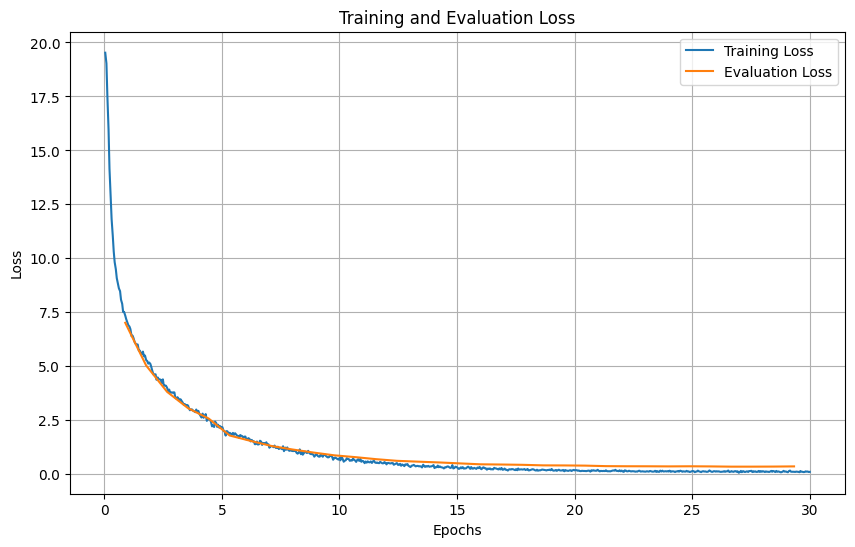

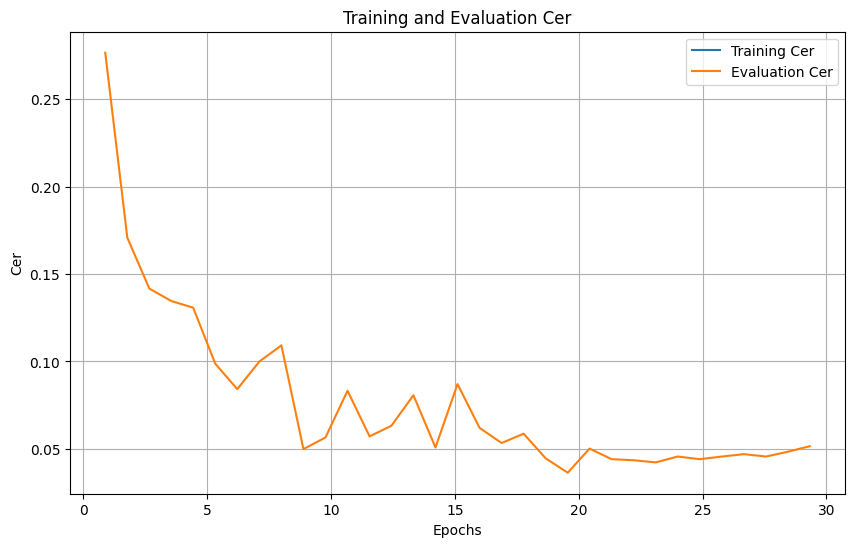

In [7]:
# Extract logs for plotting
train_logs = trainer.state.log_history

# Plotting the training and evaluation curves
def plot_metrics(logs, metric_name):
    train_steps = []
    train_values = []
    eval_steps = []
    eval_values = []

    for log in logs:
        if 'loss' in log and metric_name == 'loss':
            if 'epoch' in log:
                train_steps.append(log['epoch'])
                train_values.append(log['loss'])
        elif f'eval_{metric_name}' in log:
            if 'epoch' in log:
                eval_steps.append(log['epoch'])
                eval_values.append(log[f'eval_{metric_name}'])

    plt.figure(figsize=(10, 6))
    plt.plot(train_steps, train_values, label=f'Training {metric_name.capitalize()}')
    plt.plot(eval_steps, eval_values, label=f'Evaluation {metric_name.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.capitalize())
    plt.title(f'Training and Evaluation {metric_name.capitalize()}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot loss, CER, WER, and BLEU
plot_metrics(train_logs, 'loss')
plot_metrics(train_logs, 'cer')
# plot_metrics(train_logs, 'wer')
# plot_metrics(train_logs, 'bleu')


In [8]:
import re
import os
from PIL import Image
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# model_path = model_dir
# processor_path = model_dir

# # Load the fine-tuned model and processor
# processor = TrOCRProcessor.from_pretrained(processor_path)
# model = VisionEncoderDecoderModel.from_pretrained(model_path).to(device)

# Function to generate text for a single image segment
def generate_text_from_image_segment(image_path):
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)  # Move pixel_values to the correct device
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

# Base directory where the page folders are located
base_dir = "../../data/test" 

def sort_key(filename):
    """
    Custom sort function to extract the segment number from the filename
    and use it as the key for sorting.
    """
    match = re.search(r"(\d+)\.jpg", filename)
    if match:
        return int(match.group(1))
    return -1  # Return -1 if the pattern doesn't match

# Iterate through each page's folder
for page_folder in sorted(os.listdir(base_dir)):
    page_path = os.path.join(base_dir, page_folder)
    if os.path.isdir(page_path):
        print(f"Processing {page_folder}:")
        page_texts = []

        # Sort the line segment images numerically based on the segment number
        line_segment_images = sorted([f for f in os.listdir(page_path) if f.endswith('.jpg')], key=sort_key)

        # Iterate through each sorted line segment in the page folder
        for line_segment_image in line_segment_images:
            line_segment_path = os.path.join(page_path, line_segment_image)
            line_text = generate_text_from_image_segment(line_segment_path)
            page_texts.append((line_segment_image, line_text))
        
        # Sort the generated texts based on the filenames
        page_texts.sort(key=lambda x: sort_key(x[0]))

        # Print the texts in sorted order
        for line_segment_image, line_text in page_texts:
            print(f"  {line_segment_image}: {line_text}")

        # Compile and display the full page's text
        full_page_text = "\n".join([text for _, text in page_texts])
        print(f"\nFull text for {page_folder}:")
        print(full_page_text)
        print("\n" + "="*50 + "\n")

cuda
Processing 2:


/vol/bitbucket/ur23/g/lib/python3.10/site-packages/transformers/generation/utils.py:1197: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


  1.jpg: dava al pastigo, y que Nielasa se devanto a la venta
  2.jpg: na del aposento a preguntar quien era el que dava
  3.jpg: goloes. Ysabel de natural dize, que estava las tres
  4.jpg: en el aposento donde dormian, y que aun no se avia
  5.jpg: desnudado, y que bacaton al pastigo a hablar con
  6.jpg: den Pedro. Preguntoseles tambien, con que llave
  7.jpg: estava corrado el pastigo al tie mpo que le delquuzio
  8.jpg: con Pedro, y Noolasa dize, que estava corrado con
  9.jpg: llave de laba, yque el dicho don Pedro con la Maga
  10.jpg: o muchete quito el escalos del posigo de la parte
  11.jpg: de a fuera, y con la daga lexanto la puerta hazia atri-
  12.jpg: ha, y compio la certadura, y que aviendolo echado
  13.jpg: de ver su ama otro dia, le avian dicho, que los mu-
  14.jpg: chachos jugando lo avian hecho, y ella lo avia adere
  15.jpg: zado, en lo qual cortestan todas ttes, y doña Iladel
  16.jpg: dize, que duraria un querto de ora el tomper el po-
  17.jpg: stigo. Ofregunt